In this notebook I try to count the number of objects in this wide field image, serving as a catalog of sorts, and further down the line find a way to distinguish between stars, galaxies, asteroids, etc. 

In [1]:
#import dependencies
%matplotlib inline


import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
from sklearn.preprocessing import normalize
from cv2 import COLOR_GRAY2RGB
from imutils import contours
from skimage import measure
import numpy as np
import imutils
import cv2

In [14]:
#create and load helper function(s)
def resize_with_pad(img, img_size):
    """Resizes an image, and pads it to assure same dimensionality as the others. 
    Works for RGB images.
    
    The size ends  as a square shaped array, so only one length (img_size) is specified. 
    """
    height, width, _ = img.shape
    ratio = img_size / max(height, width)
   # print(ratio)
    if ratio < 1:
        img = cv2.resize(img, (int(ratio * width), int(ratio * height)))
    padding = ((img_size - img.shape[0], 0), (img_size - img.shape[1],0), (0,0))

    return np.pad(img, padding, 'constant')

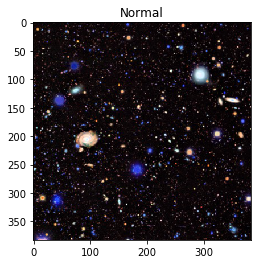

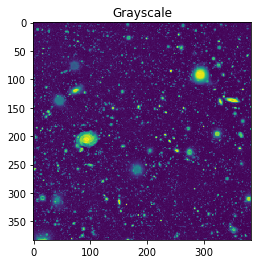

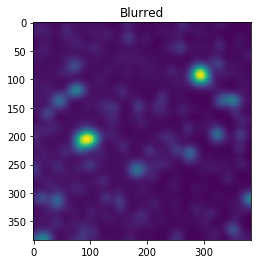

In [3]:
plt.title("Normal")
plt.imshow(image)
plt.figure()
plt.title("Grayscale")
plt.imshow(gray)
plt.figure()
plt.title("Blurred")
plt.imshow(blurred)

By blurring the image, this effectively retains all of the qualities of the image, and spreads out the brightness of a galaxy for example so that the whole will remain when filtering is done further down. 

In [4]:
thresh = cv2.threshold(blurred, 100, 200, cv2.THRESH_BINARY)[1]

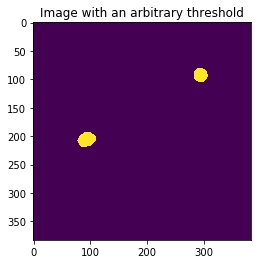

In [5]:
plt.title("Image with an arbitrary threshold")
plt.imshow(thresh)

I'm the first to admit this threshold is very arbitrary, but it has allowed me to retain the largest and brightest objects in this field of view. 

Going into a little bit about why I don't have any better reasoning behind this threshold, the brightness of these objects has many factors, object distance, size, type, even potentially atmospheric effects. None of which I feel qualified at this point to convert into a grayscale value. For more information, I've looked here and https://www.spacetelescope.org/projects/fits_liberator/improc/ may come back to this for better insight. 

In [6]:
#These labels correspond to the different regions. 
labels = measure.label(thresh, neighbors=8, background=0) #Label connected regions of an integer array.
#8 means consider diagonal values too. 
mask = np.zeros(thresh.shape, dtype="uint8")

In [29]:
image_identification_dataset = [] #array for prediction with a CNN. 
cropped_images = []
for label in np.unique(labels):  
    image = cv2.imread(imagefile)  #read in the image
  #  print(label)
# if this is the background label, ignore it
    if label == 0:
        continue
 #as done here!
    # otherwise, construct the label mask and count the
    # number of pixels 
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255  #immediately make it as large as possible
   # plt.figure()
    for i in range(len(labelMask)):
        for j in range(len(labelMask[i])):  #create a mask on the array, revealing only the important object at that time. 
            if labelMask[i][j] == 0:  
                labelMask[i][j] = False
            else:
                labelMask[i][j] = True
    for color in range(np.shape(image)[2]):
    #print(image[:,:,color]) #this is one particular color 
        image[:,:,color] = np.multiply(labelMask,image[:,:,color])  #apply masking to each RGB filter
    image_identification_dataset.append(image)  #append the rgb image to the array
    
    
#now for each of these images,crop them a smaller size but only retain important features. This will be useful for resizing but retaining a useful spatial 
#structure later on (probably)

for image in image_identification_dataset:
    cropped_rows = []
    cropped = []
    for row in range(len(image)):
        if sum(sum(image[row])) != 0:
            cropped_rows.append(image[row])
        
    cropped_rows = np.array(cropped_rows)
    for i in range(np.shape(cropped_rows)[1]):
        if sum(sum(cropped_rows[:,i,:])) != 0:
            cropped.append(cropped_rows[:,i,:])
    cropped = np.array(cropped)
    
    cropped_images.append(cropped)
cropped_images = np.array(cropped_images)


Note that this method of cropping flips the image, but that does not seem to affect the future classication task in any way. 

In [30]:
for images in cropped_images:
    print("height: ", images.shape[0])
    print("width: ", images.shape[1])

height:  25
width:  25
height:  32
width:  26


In [38]:
resized_images = []

for image in cropped_images:
    resized_images.append(resize_with_pad(image,55))

So repeat this operation for each of the new objects, and resize all based on the  max size or some other metric and pad the others to retain the proper aspect ratio. 

# Comparison of one object vs. the whole thing vs. it cropped/resized.

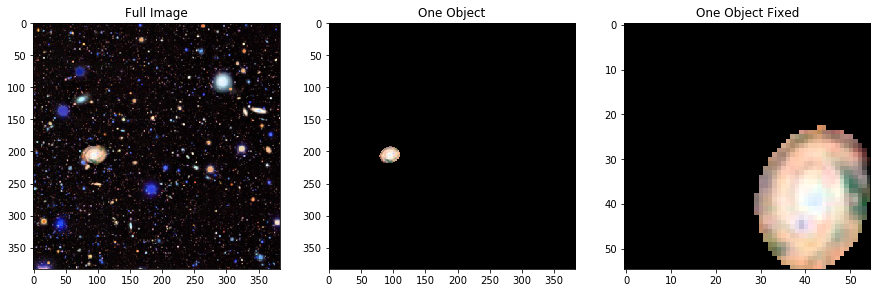

In [39]:
#plt.imshow(image_identiciation_dataset[3])
imagefile = '../data/lsst.jpg'

image_full = cv2.imread(imagefile)

fig = plt.figure(figsize=(15,20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(image_full)
ax1.set_title("Full Image")

ax2 = fig.add_subplot(1,3,2)
ax2.set_title("One Object")
ax2.imshow(image_identification_dataset[1])

ax3 = fig.add_subplot(1,3,3)
ax3.set_title("One Object Fixed")
ax3.imshow(resized_images[1])
